# TODO
1. ~~wyznaczanie pojedynczych puzzli~~ - Mikołaj
2. ~~ponumerowanie puzzli~~ - Mikołaj
3. ~~wyznaczanie krawędzi~~ - Bartosz
4. ~~wyznaczanie narożników~~ - Bartosz
5. wykorzystanie narożników do podziału krawędzi na 4 boki
6. szukanie patternów/dopasowywanie krawędzi i/lub kolorów

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

In [ ]:
def remove_holes(img):
    im_in = img
    th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
    # Copy the thresholded image.
    im_floodfill = im_th.copy()
 
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    return im_out

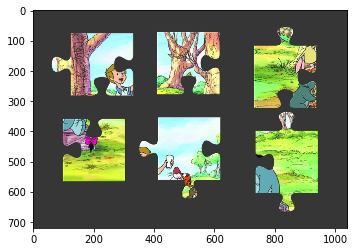

In [ ]:
def draw(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
#puchatek_puzzle_1
#cat_puzzle
#pawel1
#pawel2
#xd
chosen_img = 'pawel2.jpg'
img = cv2.imread(os.path.join('img', chosen_img))
#img2 = cv2.copyMakeBorder(img2, 50, 50, 50, 50, cv2.BORDER_REPLICATE, None)
draw(img)




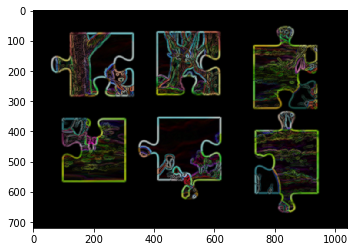

In [23]:
blur = cv2.GaussianBlur(img, (7, 7), 2)
h, w = img.shape[:2]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
draw(gradient)

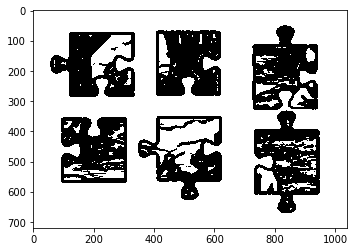

In [25]:
lowerb = np.array([0, 0, 0])
upperb = np.array([15,15,15])
binary = cv2.inRange(gradient, lowerb, upperb)

kern = np.ones((5,5),np.uint8)


test = remove_holes(binary)

erosion = cv2.erode(test, kern, iterations=3)
erosion = cv2.dilate(erosion, kern, iterations=1)
draw(erosion)
binary=erosion


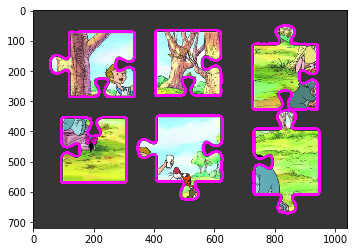

In [27]:
tmp = cv2.imread(os.path.join('img', chosen_img))
edged = cv2.Canny(binary, 10, 250)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
im2, cnts, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,)

for i in range(len(cnts)):
   if hierarchy [0,i,3] == -1:
       cv2.drawContours(tmp,cnts,i,(255,0,255), 5, cv2.FILLED)

draw(tmp)
print("Found %d objects." % len(cnts))
#draw(closed)


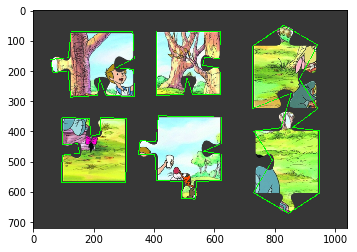

In [29]:
mask = np.zeros(img.shape, dtype="uint8")
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)

img3 = cv2.bitwise_and(img, mask)
draw(img3)


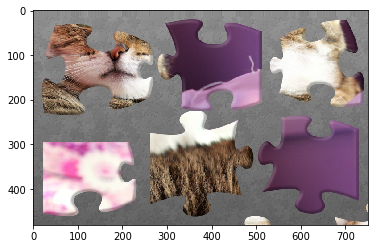

In [ ]:
def add_padding(img, size=256):
    new_im = cv2.copyMakeBorder(img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, None)
    return new_im


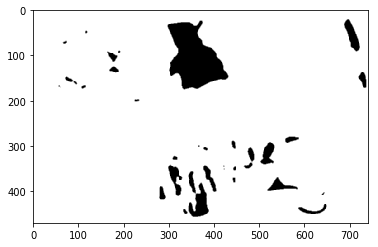

In [21]:
col=0
row=0
if len(cnts)%2 == 0:
    col = 2
    row = int(len(cnts)/2)
else:
    col = 1
    row = len(cnts)
fig = plt.figure(figsize=(12,12))
for i in range(1, col * row + 1):
    fig.add_subplot(row, col, i)
    x,y,w,h = cv2.boundingRect(cnts[i-1])
    if(w>50 and h>50):
        new_img=img[y:y+h, x:x+w]         
    else:
        new_img = np.zeros([50, 50], dtype="uint8")
    plt.imshow(new_img)
    #draw(add_padding(new_img))
    draw(new_img)
    
plt.show()

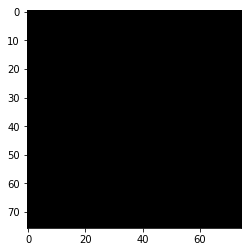

In [228]:
dst = cv2.cornerHarris(np.float32(loc),2,3,0.04)
dst = cv2.dilate(dst,None)
draw(np.uint8(dst))

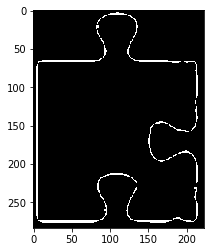

In [82]:
l = np.zeros((dst.shape[0], dst.shape[1]), dtype=np.uint8)

l[dst<0.03*np.min(dst)]=[255]
l[dst>0.03*np.max(dst)]=[255]

draw(l)

In [83]:
lines = cv2.HoughLines(np.uint8(l), 0.1, np.pi/180, 100)

In [84]:
li = []
for el in lines:
    li.append(el[0])

wyn = [[li[0]]]    

res = [li[0]]

for i in range(1, len(li)):
    flag = False
    for k in range(len(res)):
        if (res[k][0]-5 < li[i][0] and li[i][0] < res[k][0]+5) and (res[k][1]-5 < li[i][1] and li[i][1] < res[k][1]+5):
            wyn[k].append(li[i])
            flag = True
    if not flag:
        wyn.append([li[i]])
        res.append(li[i])

moments = []
        
for el in wyn:
    a, b, c = 0, 0, 0
    for e in el:
        a += e[0]
        b += e[1]
        c += 1
    moments.append([a/c, b/c])
    
moments

[[4.9500002066294355, 0.0],
 [212.4499969482422, 0.0],
 [65.95000457763672, 1.5707963705062866],
 [274.45001220703125, 1.5707963705062866]]

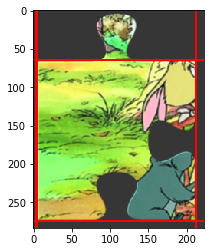

In [85]:
aaaa = puzz.copy()
points = []

for el in moments:
    rho,theta = el[0], el[1]
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    points.append([[x1,y1],[x2,y2]])
    
    cv2.line(aaaa, (x1, y1), (x2,y2), (0,0,255), 2)
    
draw(aaaa)

In [86]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [87]:
corners = set()
for i in range(len(points)):
    for k in range(len(points)):
        lx = line_intersection(points[i], points[k])
        if lx is not None:
            corners.add(lx)
            
corners = np.array(list(corners), dtype=np.int32)
corners

array([[  4, 274],
       [212, 274],
       [  4,  65],
       [212,  65]])

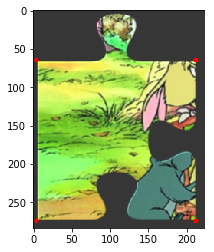

In [73]:
aaaa = puzz.copy()
for el in corners:
    cv2.circle(aaaa, (el[0], el[1]), 3, (0,0,255), -1)
draw(aaaa)

In [ ]:
lu = corners[0]
pu = corners[1]
ld = corners[2]
pd = corners[3]

cx, cy = np.int32(line_intersection([lu,pd],[pu,ld]))

aaaa = puzz.copy()

up = []
down = []
left = []
right = []

padl, padr, padu, padd = 0, 0, 0, 0 

for i in range(0, cy):
    if l[0, cx] != l[i, cx]:
        padu = i
        break

for i in range(l.shape[0]-1, cy, -1):
    if l[l.shape[0]-1, cx] != l[i, cx]:
        padd = i
        break
        
for i in range(0, cx):
    if l[cy, 0] != l[cy, i]:
        padl = i
        break
        
for i in range(l.shape[1]-1, cx, -1):
    if l[cy, l.shape[1]-1] != l[cy, i]:
        padr = i
        break
        
for i in range(l.shape[0]):
    for k in range(l.shape[1]):
        if l[i,k] != 0:
            if k >= lu[1]+5 and k <= pu[1]-5 and (i <= padu+5 or i <= np.mean([lu[0],pu[0]])+5):
                aaaa[i,k]=[0,0,255]
                up.append([i,k])
            if k > ld[1]+5 and k < pd[1]-5 and (i >= padd-5 or i>=np.mean([ld[0],pd[0]])-5):
                aaaa[i,k]=[0,255,255]
                down.append([i,k])
            if i > lu[0]+5 and i < ld[0]-5 and (k <= padl+5 or k<=np.mean([lu[1],ld[1]])+5):
                aaaa[i,k]=[0,120,255]
                left.append([i,k])
            if i > pu[0]+5 and i < pd[0]-5 and (k >= padr-5 or k>=np.mean([pu[0],pd[0]])-5):
                aaaa[i,k]=[255,0,255]
                right.append([i,k])
            
draw(aaaa)


In [ ]:
def check_slides(up, down, left, right):
    if np.std(np.array(up)[:,0]) < 5.0:
        print('góra')
    if np.std(np.array(down)[:,0]) < 5.0:
        print('dół')
    if np.std(np.array(left)[:,1]) < 5.0:
        print('lewo')
    if np.std(np.array(right)[:,1]) < 5.0:
        print('prawo')

check_slides(up, down, left, right)
